This notebook contains code for extracting box and turtlebot locations from an image using april tags.

In [80]:
import cv2
import apriltag
import numpy as np
import matplotlib.pyplot as plt

from architect.components.geometry.transforms_2d import rotation_matrix_2d

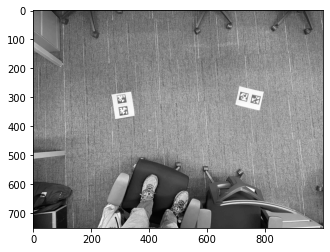

In [90]:
# Read image, downscale, and convert to grayscale
# img = cv2.imread('4tags.jpg', cv2.IMREAD_COLOR)
# img = cv2.imread('4tags_rotated.jpg', cv2.IMREAD_COLOR)
img = cv2.imread('4tags_zoomed.jpg', cv2.IMREAD_COLOR)
r = 1000.0 / img.shape[1]
dim = (1000, int(img.shape[0] * r))
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
disp_img = img.copy()

plt.imshow(gray, cmap="gray")

-------
-0.1402867410262799
[ 1.0000000e-01 -6.6835715e-10]
-------
-0.15437184738965287
[ 1.000000e-01 -7.490725e-11]
theta relative to tag 0: -0.014085106363372984
-------
1.8019049867259924
[ 1.0000000e-01 -4.2263477e-09]
theta relative to tag 0: 1.9421917277522722
-------
1.7986200367557008
[1.0000000e-01 4.9058992e-09]
theta relative to tag 0: 1.9389067777819806
-0.1402867410262799


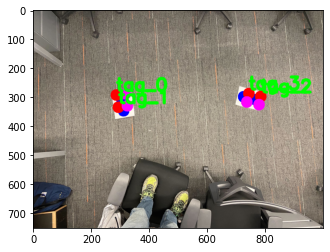

In [91]:
# Set up the APRIL tag detector
options = apriltag.DetectorOptions(families="tag36h11")
detector = apriltag.Detector(options)

# Detect APRIL tags in the image
results = detector.detect(gray)

disp_img = img.copy()
for tag in results:
    (c0, c1, _, _) = tag.corners
    ptB = (int(c1[0]), int(c1[1]))
    ptA = (int(c0[0]), int(c0[1]))
    
    tag_side_m = 0.1
    origin_tag_side_length_px = np.sqrt((c0[0] - c1[0]) ** 2 + (c0[1] - c1[1]) ** 2)
    scale_m_per_px = tag_side_m / origin_tag_side_length_px
    
    # draw the bounding box of the AprilTag detection
    cv2.line(disp_img, ptA, ptB, (0, 255, 0), 2)

    # draw the center (x, y)-coordinates of the AprilTag
    (cX, cY) = (int(tag.center[0]), int(tag.center[1]))
    cv2.circle(disp_img, (cX, cY), 20, (0, 0, 255), -1)
    
    # Draw the first two corners
    cv2.circle(disp_img, (ptA[0], ptA[1]), 20, (255, 0, 0), -1)
    cv2.circle(disp_img, (ptB[0], ptB[1]), 20, (255, 0, 255), -1)

    # draw the tag ID on the image
    cv2.putText(disp_img, f"tag_{tag.tag_id}", (ptA[0], ptA[1] - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 10)
    
    p_C0C1_Camera_px = (np.array(c1) - np.array(c0))
    p_CameraO = np.array([cX, cY])
    theta_CameraO = np.arctan2(p_C0C1_Camera_px[1], p_C0C1_Camera_px[0])
    R_CameraO = rotation_matrix_2d(theta_CameraO)
    R_OCamera = R_CameraO.T
    
    p_OC1_Camera = (np.array(ptB) - p_CameraO) * scale_m_per_px
    p_C0C1_Camera = p_C0C1_Camera_px * scale_m_per_px
    p_C0C1_O = R_OCamera @ p_C0C1_Camera
    print("-------")
    print(theta_CameraO)
    print(p_C0C1_O)
    
    if tag.tag_id == 0:
        theta_origin = theta_CameraO
    else:
        print(f"theta relative to tag 0: {theta_CameraO - theta_origin}")
    
plt.imshow(disp_img, cmap="gray", origin="upper")
print(theta_origin)

Detected Poses:
[[ 1.77823275e-03 -1.35997459e-01  1.40851064e-02]
 [ 1.48107123e+00 -2.17505470e-01 -1.94219173e+00]
 [ 1.35479748e+00 -1.68014288e-01 -1.93890678e+00]]
tag2 -> tag3 distance: 0.1356260939116593
tag0 -> tag1 distance: 0.13600908442342913


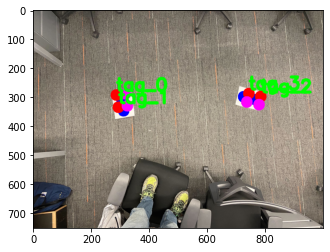

In [97]:
def detect_apriltags(img: np.ndarray):
    """Detect all apriltags in the given grayscale image.

    args:
        img: grayscale image
    returns:
        a list of apriltag DetectionBase objects indicating the
        detected apriltags
    """
    # Set up the APRIL tag detector
    options = apriltag.DetectorOptions(families="tag36h11")
    detector = apriltag.Detector(options)

    # Detect APRIL tags in the image
    results = detector.detect(img)

    return results

def turtlebot_box_poses_from_image(img: np.ndarray):
    """Get the turtlebot and box poses from an image

    args:
        img: grayscale image
    returns:
        Three np.arrays of (x, y, theta) for the position and orientation of
        the box and two turtlebots. (x, y) are in meters relative to an origin
        tag, while theta is in radians relative to the x-axis of the origin tag.

        Could return None if a failure occurs.
    """
    # define ID numbers for the four tags we expect to see.
    origin_tag_id = 0
    box_tag_id = 1
    turtle1_tag_id = 2
    turtle2_tag_id = 3

    # define the size of the origin tag to provide a scale bar for the image
    origin_tag_side_length_m = 0.1

    # Get the apriltags from the image
    detections = detect_apriltags(img)
    origin_tag = None
    box_tag = None
    turtle1_tag = None
    turtle2_tag = None
    for d in detections:
        if d.tag_id == origin_tag_id:
            origin_tag = d
        elif d.tag_id == box_tag_id:
            box_tag = d
        elif d.tag_id == turtle1_tag_id:
            turtle1_tag = d
        elif d.tag_id == turtle2_tag_id:
            turtle2_tag = d

    # Fail if not all tags were detected
    if (
        origin_tag is None
        or box_tag is None
        or turtle1_tag is None
        or turtle2_tag is None
    ):
        return None

    # Use the size of the origin tag to set the scale for the image
    (co0, co1, _, _) = origin_tag.corners
    origin_tag_side_length_px = np.sqrt(
        (co0[0] - co1[0]) ** 2 + (co0[1] - co1[1]) ** 2
    )
    scale_m_per_px = origin_tag_side_length_m / origin_tag_side_length_px

    # Get the center of the origin in px
    origin_px = np.array(origin_tag.center)

    # Get orientation of the origin
    # co0 is the upper left corner, co1 is the upper right, so co0 -> co1 points
    # along the x axis of the origin
    p_Co0Co1_Camera_px = np.array(co1) - np.array(co0)
    ydiff = p_Co0Co1_Camera_px[1]
    xdiff = p_Co0Co1_Camera_px[0]
    theta_CameraO = np.arctan2(ydiff, xdiff)

    # Make a 2D rotation to convert from camera to origin frames
    R_CameraO = rotation_matrix_2d(theta_CameraO)
    R_OCamera = R_CameraO.T

    # Process the rest of the points
    tags = [box_tag, turtle1_tag, turtle2_tag]
    poses = np.zeros((3, 3))
    for idx, tag in enumerate(tags):
        # Get tag position in pixels relative to origin in camera frame
        p_OTag_Camera_px = np.array(tag.center) - origin_px

        # Convert to meters
        p_OTag_Camera_m = p_OTag_Camera_px * scale_m_per_px

        # Convert to origin frame
        p_OTag_m = R_OCamera @ p_OTag_Camera_m

        # Store position
        poses[idx, :2] = p_OTag_m

        # Get tag orientation in camera frame
        (ctag0, ctag1, _, _) = tag.corners
        p_Ctag0Ctag1_Camera_px = np.array(ctag1) - np.array(ctag0)
        ydiff = p_Ctag0Ctag1_Camera_px[1]
        xdiff = p_Ctag0Ctag1_Camera_px[0]
        theta_CameraTag = np.arctan2(ydiff, xdiff)

        # Convert to origin frame
        theta_OTag = theta_CameraTag - theta_CameraO

        # Save orientation
        poses[idx, 2] = theta_OTag

    # Flip y axis and orientation to account for image axes
    poses[:, 1:] *= -1.0
    
    return poses


poses = turtlebot_box_poses_from_image(gray)
plt.imshow(disp_img, cmap="gray", origin="upper")
print("Detected Poses:")
print(poses)
print(f"tag2 -> tag3 distance: {np.linalg.norm(poses[1, :2] - poses[2, :2])}")
print(f"tag0 -> tag1 distance: {np.linalg.norm(poses[0, :2])}")